In [3]:

%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 746 ms, sys: 330 ms, total: 1.08 s
Wall time: 2.74 s


In [4]:

%%time

sequence_length = 40
dataset = create_dataset('amazon-books', sample_num=100000, sequence_length=sequence_length, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 58.9 s, sys: 1.97 s, total: 1min
Wall time: 1min 3s


In [5]:
%%time

import numpy as np
from tqdm import tqdm

def auxiliary_sample(X, sample_set):
    pos_sample = X[:, 1: -1]
    neg_sample = torch.zeros_like(pos_sample)
    for i in tqdm(range(pos_sample.shape[0])):
        for j in range(pos_sample.shape[1]):
            if pos_sample[i, j] > 0:
                idx = np.random.randint(len(sample_set))
                while sample_set[idx] == pos_sample[i, j]:
                    idx = np.random.randint(len(sample_set))
                neg_sample[i, j] = sample_set[idx]
            else:
                break
    return  neg_sample


neg_sample = auxiliary_sample(train_X, dataset.cate_set)
train_X_neg = torch.hstack([train_X, neg_sample])


100%|██████████| 80000/80000 [03:28<00:00, 383.44it/s]

CPU times: user 3min 27s, sys: 1.07 s, total: 3min 28s
Wall time: 3min 28s


In [6]:
   
class Dice(nn.Module):
    
    def __init__(self):
        super(Dice, self).__init__()
        self.alpha = nn.Parameter(torch.zeros((1, )))
        
    def forward(self, x):
        avg = x.mean(dim=0)
        std = x.std(dim=0)
        norm_x = (x - avg) / std
        p = torch.sigmoid(norm_x)

        return x.mul(p) + self.alpha * x.mul(1 - p)


class Attention(nn.Module):
    
    def __init__(self, embed_dims):
        super(Attention, self).__init__()
        embed_dim1, embed_dim2 = embed_dims
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim1 + embed_dim2 + embed_dim1 * embed_dim2 , 36),
            Dice(),
            nn.Linear(36, 1),
        )
    
    def forward(self, packed: PackedSequence, key):
        # key shape: (batch_size, embed_dim)
        # x shape: (num_x, embed_dim)
        x, batch_sizes, sorted_indices, unsorted_indices = packed
        key = key[sorted_indices]
        idx_list = []
        for batch_size in batch_sizes:
            idx_list.extend(range(batch_size))
        key = key[idx_list]
                
        # outer product
        i1, i2 = [], []
        for i in range(x.shape[-1]):
            for j in range(key.shape[-1]):
                i1.append(i)
                i2.append(j)
        p = x[:, i1].mul(key[:, i2]).reshape(x.shape[0], -1)
        
        att = self.mlp(torch.hstack([x, p, key]))
        return att


class AUGRUCell(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(AUGRUCell, self).__init__()
        
        self.update_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, 1),
            nn.Sigmoid()
        )
        self.reset_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, 1),
            nn.Sigmoid()
        )
        
        self.candidate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
    
    def forward(self, x, h, att):
        u = self.update_gate(torch.hstack([x, h]))
        u = att * u
        r = self.reset_gate(torch.hstack([x, h]))
        tilde_h = self.candidate(torch.hstack([x, h * r]))
        h = (1 - u) * h + u * tilde_h
        return h

    
class AUGRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, embed_dim=4):
        super(AUGRU, self).__init__()
        self.hidden_size = hidden_size
        
        self.attention = Attention([hidden_size, embed_dim])
        self.augru_cell = AUGRUCell(input_size, hidden_size)
        
    
    def forward(self, packed: PackedSequence, key, h=None):
        x, batch_sizes, sorted_indices, unsorted_indices = packed
        att = self.attention(packed, key)
        device = x.device
        if h == None:
            h = torch.zeros(batch_sizes[0], self.hidden_size, device=device)
            
        output = torch.zeros(x.shape[0], self.hidden_size)
        output_h = torch.zeros(batch_sizes[0], self.hidden_size, device=device)
        
        start = 0
        for batch_size in batch_sizes:
            _x = x[start: start + batch_size]
            _att = att[start: start + batch_size]
            _h = h[:batch_size]
            h = self.augru_cell(_x, _h, _att)
            output[start: start + batch_size] = h
            output_h[:batch_size] = h
            start += batch_size
        
        return PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices), output_h[unsorted_indices]


class DeepInterestEvolutionNetwork(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(DeepInterestEvolutionNetwork, self).__init__()
        hidden_size = embed_dim
        # 商品 embedding 层
        self.embed = Embedding(field_dims[0], embed_dim)
        
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.augru = AUGRU(hidden_size, hidden_size, embed_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim + hidden_size, 200),
            Dice(),
            nn.Linear(200, 80),
            Dice(),
            nn.Linear(80, 1)
        )
        
    def forward(self, x, neg_sample=None):
        behaviors_ad_embeddings = self.embed(x)  # (batch_size, num_behaviors+1, embed_dim)
        
        lengths = (x[:, :-1] > 0).sum(dim=1).cpu()
        packed_behaviors = pack_padded_sequence(behaviors_ad_embeddings, lengths, batch_first=True, enforce_sorted=False)
        packed_gru_output, _ = self.gru(packed_behaviors)
        augru_output, h = self.augru(packed_gru_output, behaviors_ad_embeddings[:, -1])
        
#         h = _.view(_.shape[1], -1)
        concated = torch.hstack([h, behaviors_ad_embeddings[:, -1]])
        output = self.mlp(concated)
        output = torch.sigmoid(output)
        
        if neg_sample is None:
            return output
        else:
            # auxiliary loss part
            gru_output, _ = pad_packed_sequence(packed_gru_output, batch_first=True)
            gru_embedding = gru_output[:, 1:][neg_sample > 0]
            
            pos_embedding = behaviors_ad_embeddings[:, 1:-1][neg_sample > 0]
            neg_embedding = self.embed(neg_sample)[neg_sample > 0]

            pred_pos = (gru_embedding * pos_embedding).sum(dim=1)
            pred_neg = (gru_embedding * neg_embedding).sum(dim=1)
            auxiliary_output = torch.sigmoid(torch.cat([pred_pos, pred_neg], dim=0)).reshape(2, -1)
            
            return output, auxiliary_output


In [7]:
from utils.utils import BatchLoader, EarlyStopper
import matplotlib.pyplot as plt

class DIENTrainer(Trainer):
    
    def __init__(self, model, optimizer, criterion, batch_size=None):
        super(DIENTrainer, self).__init__(model, optimizer, criterion, batch_size)
    
    def train(self, train_X_neg, train_y, epoch=100, trials=None, valid_X=None, valid_y=None):
        if self.batch_size:
            train_loader = BatchLoader(train_X_neg, train_y, self.batch_size)
        else:
            # 为了在 for b_x, b_y in train_loader 的时候统一
            train_loader = [[train_X_neg, train_y]]

        if trials:
            early_stopper = EarlyStopper(self.model, trials)

        train_loss_list = []
        valid_loss_list = []

        for e in tqdm(range(epoch)):
            # train part
            self.model.train()
            train_loss_ = 0
            for b_x, b_y in train_loader:
                self.optimizer.zero_grad()
                seq_len = b_x.shape[1] // 2
                pred_y, auxiliary_y = self.model(b_x[:, :seq_len+1], b_x[:, -seq_len+1:])
                
                auxiliary_true = torch.cat([torch.ones_like(auxiliary_y[0]), torch.zeros_like(auxiliary_y[1])], dim=0).view(2, -1)
                auxiliary_loss = self.criterion(auxiliary_y, auxiliary_true)
                auxiliary_loss.backward(retain_graph=True)
                
                train_loss = self.criterion(pred_y, b_y)
                train_loss.backward()
                
                self.optimizer.step()

                train_loss_ += train_loss.detach() * len(b_x)

            train_loss_list.append(train_loss_ / len(train_X_neg))

            # valid part
            if trials:
                valid_loss, valid_metric = self.test(valid_X, valid_y)
                valid_loss_list.append(valid_loss)
                if not early_stopper.is_continuable(valid_metric):
                    break

        if trials:
            self.model.load_state_dict(early_stopper.best_state)
            plt.plot(valid_loss_list, label='valid_loss')

        plt.plot(train_loss_list, label='train_loss')
        plt.legend()
        plt.show()

        print('train_loss: {:.5f} | train_metric: {:.5f}'.format(*self.test(train_X, train_y)))

        if trials:
            print('valid_loss: {:.5f} | valid_metric: {:.5f}'.format(*self.test(valid_X, valid_y)))

 64%|██████▎   | 381/600 [17:51<10:15,  2.81s/it]


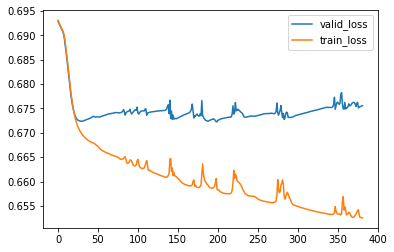

train_loss: 0.65691 | train_metric: 0.62397
valid_loss: 0.67315 | valid_metric: 0.60779
test_loss:  0.67250 | test_auc:  0.60779
CPU times: user 17min 41s, sys: 3.49 s, total: 17min 45s
Wall time: 17min 52s


In [8]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

dien = DeepInterestEvolutionNetwork(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(dien.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = DIENTrainer(dien, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X_neg, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_metric))